<a href="https://colab.research.google.com/github/Majd-Wardeh/NN_project_colab/blob/branch1/NN_project_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-05-06 07:29:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   203MB/s    in 0.4s    

2020-05-06 07:29:25 (203 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
%matplotlib inline
import io
import os
from os import path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [0]:
def load_data(images_dir, pd_file):
  data = pd_file 
  imgs = []
  labels = []
  points = []
  not_found_images_counter = 0
  listdir = os.listdir(images_dir)
  for index in data.index.values:
    image_file_name = 'screen_640x480_{}.jpg'.format(data['pic number'][index])
    #if path.exists(images_dir + '/' + image_file_name):
    if image_file_name in listdir:
      r = data['r'][index]
      phai = data['phai'][index]
      theta = data['theta'][index]
      labels.append([r, phai, theta])
      imgs.append(image_file_name)
    else:
      not_found_images_counter += 1
      #print("{} not found!".format(image_file_name))

  print("found {} images".format(len(imgs)), "  # of not found images {}".format(not_found_images_counter))
  return imgs, labels

In [0]:
def create_train_validation_dataframe(csv_file, random_seed=0):
  data = pd.read_csv(csv_file)

  train_df = data.copy()
  valid_df = data.copy()

  remove_training = []
  remove_validation = []

  np.random.seed(random_seed)
  for index in data.index.values:
    rand = np.random.rand()
    if rand < 0.4:
      remove_validation.append(index)
    else:
      remove_training.append(index)

  train_df = train_df.drop(remove_training)
  valid_df = valid_df.drop(remove_validation)

  print("total images: ", len(list(data.index.values)))
  print("number of training images: {}".format(len(train_df['pic number'])))
  print("number of validation images: {}".format(len(valid_df['pic number'])))

  # train_df.to_csv("/content/drive/My Drive/NN_project/dataset/train_debug.csv")
  return  train_df, valid_df

In [18]:
base_dir = "/content/drive/My Drive/NN_project/dataset"
train_dir = os.path.join( base_dir, 'images')
validation_dir = os.path.join( base_dir, 'images')

train_df, valid_df = create_train_validation_dataframe(base_dir + '/coordinates_cleaned_0_11999.csv',\
                                                       random_seed = 425)

train_img_names, train_labels = load_data(base_dir + '/images', train_df)
valid_img_names, valid_labels = load_data(base_dir + '/images', valid_df)



total images:  11996
number of training images: 4824
number of validation images: 7172
found 4267 images   # of not found images 557
found 6324 images   # of not found images 848


In [19]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_weights_dir = '/content/drive/My Drive/NN_project/inception_weights'

pre_trained_model = InceptionV3(input_shape = (240, 320, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


flatten = layers.Flatten()(last_output)
flatten_dropedout = layers.Dropout(0.3)(flatten)

dense1 = layers.Dense(100, activation='relu')(flatten_dropedout)
dense1 = layers.Dropout(0.2)(dense1)                  
 
dense2 = layers.Dense(100, activation='relu')(dense1) 
#dense2 = layers.Dropout(0.2)(dense2)

#dense3 = layers.Dense(1024, activation='tanh')(dense2)

y_estimator = layers.Dense(3, activation='linear')(dense2)

estimation_model = Model( pre_trained_model.input, y_estimator) 
estimation_model.compile(optimizer = Adam(lr=0.001), 
              loss = 'mae')

# estimation_model.summary()

last layer output shape:  (None, 13, 18, 768)


In [0]:
import multiprocessing
import time

class Processor:
  def __init__(self, path, img_names, labels):
    self.labels = labels
    self.img_names = img_names
    self.path = path
    print("hello")

  def __call__(self, index):
    #print(index)
    img_name = self.img_names[index]
    img = Image.open(self.path + "/" + img_name) #.resize((320, 240))
    img = np.array(img, dtype=np.float32)/255.0
    label = self.labels[index]
    # label[1] = label[1]*180.0/np.pi
    # label[2] = label[2]*180.0/np.pi
    return img, label

def get_data_multiprocess(data_dir, img_names, labels, length):
  start = time.time()
  proc=Processor(data_dir, img_names, labels)
  pool=multiprocessing.Pool(processes=8)
  res = pool.map(proc,range(length))
  finish = time.time()
  print("# of images: ", len(res))
  print("time = ", finish-start)
  x_data = np.empty((length, 240, 320, 3), dtype=np.float32)
  y_data = np.empty((length, 3), dtype=np.float32)
  for i, r in enumerate(res):
    x, y = r
    x_data[i, ] = x 
    y_data[i, ] = y 
  return x_data, y_data


x_train, y_train = None, None
x_train, y_train = get_data_multiprocess(train_dir, train_img_names, train_labels, int(len(train_labels)))

x_valid, y_valid = None, None
x_valid, y_valid = get_data_multiprocess(validation_dir, valid_img_names, valid_labels, int(len(valid_img_names)))

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

hello


In [0]:
history = estimation_model.fit(x_train, y_train,
                    batch_size = 100,
                    validation_data = (x_valid, y_valid),                                 
                    steps_per_epoch = 1,
                    epochs=50)

In [0]:
load1_or_save0 = 
name = "/content/drive/My Drive/NN_project/inception_weights/weights_MAE_2layers_500each_relu_{}.h5".format(time.time())
if load1_or_save0 == 0:
  estimation_model.save_weights(name)
else:
  estimation_model.load_weights(name)

In [0]:
for layer in estimation_model.layers:
  layer.trainable = True

In [0]:
index = np.random.randint(len(train_labels))
y_pred = estimation_model.predict(np.expand_dims(x_train[index], axis=0))[0]
y_true = y_train[index]
print(y_true)
print(y_pred)
print(tf.keras.losses.mean_absolute_error(y_true, y_pred), tf.keras.losses.mean_squared_error(y_true, y_pred))

[  9.158958 108.18209   24.893665]
[ 5.62732  86.88761  18.594076]
tf.Tensor(10.375236, shape=(), dtype=float32) tf.Tensor(168.53738, shape=(), dtype=float32)


In [0]:
import numpy.linalg as la

y_pred = estimation_model.predict(x_train)
y_true = y_train

l2_norm = la.norm(y_true - y_pred, axis = 1)
print("norm of the error = ", l2_norm.shape)
print("mse = ", np.mean(l2_norm))
print("meidan = ", np.median(l2_norm))


norm of the error =  (5633,)
mse =  52.98559
meidan =  55.088097


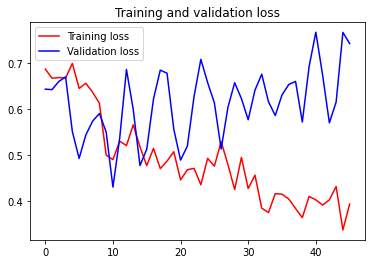

In [11]:
import matplotlib.pyplot as plt
import time
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
start = 4
end = len(loss)
loss = loss[start:end]
val_loss = val_loss[start:end]
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
#plt.savefig(base_dir + "/MAE_relu_2layers_500each_{}.png".format(time.time()))


plt.show()

In [17]:
!cp -r "drive/My Drive/NN_project/dataset/train_7_12/gate/." "drive/My Drive/NN_project/dataset/images/"

^C


In [0]:
# !ls "drive/My Drive/NN_project/dataset/train_7_12/gate"
#

In [0]:
# !rm -d -r "drive/My Drive/NN_project/dataset/images"

In [0]:
!rm '/content/drive/My Drive/NN_project/dataset/images/screen_640x480_8197.jpg'

In [0]:
# !mkdir "drive/My Drive/NN_project/dataset/images"

In [15]:
import os

for file_name in os.listdir("drive/My Drive/NN_project/dataset/validation_7_12/gate"):
   list_split = file_name.split('_')
   new_name = list_split[0] + "_640x480_" + list_split[2]
   print(file_name, new_name)
   os.rename("drive/My Drive/NN_project/dataset/validation_7_12/gate/" + file_name, \
             "drive/My Drive/NN_project/dataset/validation_7_12/gate/"+ new_name)

screen_320x240_7544.jpg screen_640x480_7544.jpg
screen_320x240_8717.jpg screen_640x480_8717.jpg
screen_320x240_11009.jpg screen_640x480_11009.jpg
screen_320x240_7654.jpg screen_640x480_7654.jpg
screen_320x240_11179.jpg screen_640x480_11179.jpg
screen_320x240_8737.jpg screen_640x480_8737.jpg
screen_320x240_9086.jpg screen_640x480_9086.jpg
screen_320x240_9722.jpg screen_640x480_9722.jpg
screen_320x240_8887.jpg screen_640x480_8887.jpg
screen_320x240_9572.jpg screen_640x480_9572.jpg
screen_320x240_11230.jpg screen_640x480_11230.jpg
screen_320x240_8854.jpg screen_640x480_8854.jpg
screen_320x240_8720.jpg screen_640x480_8720.jpg
screen_320x240_8291.jpg screen_640x480_8291.jpg
screen_320x240_10239.jpg screen_640x480_10239.jpg
screen_320x240_9654.jpg screen_640x480_9654.jpg
screen_320x240_8463.jpg screen_640x480_8463.jpg
screen_320x240_9607.jpg screen_640x480_9607.jpg
screen_320x240_7089.jpg screen_640x480_7089.jpg
screen_320x240_7827.jpg screen_640x480_7827.jpg
screen_320x240_7900.jpg screen_6